# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откроем файл с данными и изучим общую информацию. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

   total_images  last_price total_area first_day_exposition  rooms  \
0            20  13000000.0      108.0  2019-03-07T00:00:00      3   
1             7   3350000.0       40.4  2018-12-04T00:00:00      1   
2            10   5196000.0       56.0  2015-08-20T00:00:00      2   
3             0  64900000.0      159.0  2015-07-24T00:00:00      3   
4             2  10000000.0      100.0  2018-06-19T00:00:00      2   
5            10   2890000.0       30.4  2018-09-10T00:00:00      1   
6             6   3700000.0       37.3  2017-11-02T00:00:00      1   
7             5   7915000.0       71.6  2019-04-18T00:00:00      2   
8            20   2900000.0      33.16  2018-05-23T00:00:00      1   
9            18   5400000.0       61.0  2017-02-26T00:00:00      3   

  ceiling_height floors_total living_area  floor is_apartment  ...  \
0            2.7         16.0        51.0      8          NaN  ...   
1            NaN         11.0        18.6      1          NaN  ...   
2            NaN   

,total_images,rooms,floor
count,23699.000000,23699.000000,23699.000000
mean,9.858475,2.070636,5.892358
std,5.682529,1.078405,4.885249
min,0.000000,0.000000,1.000000
25%,6.000000,1.000000,2.000000
50%,9.000000,2.000000,4.000000
75%,14.000000,3.000000,8.000000
max,50.000000,19.000000,33.000000


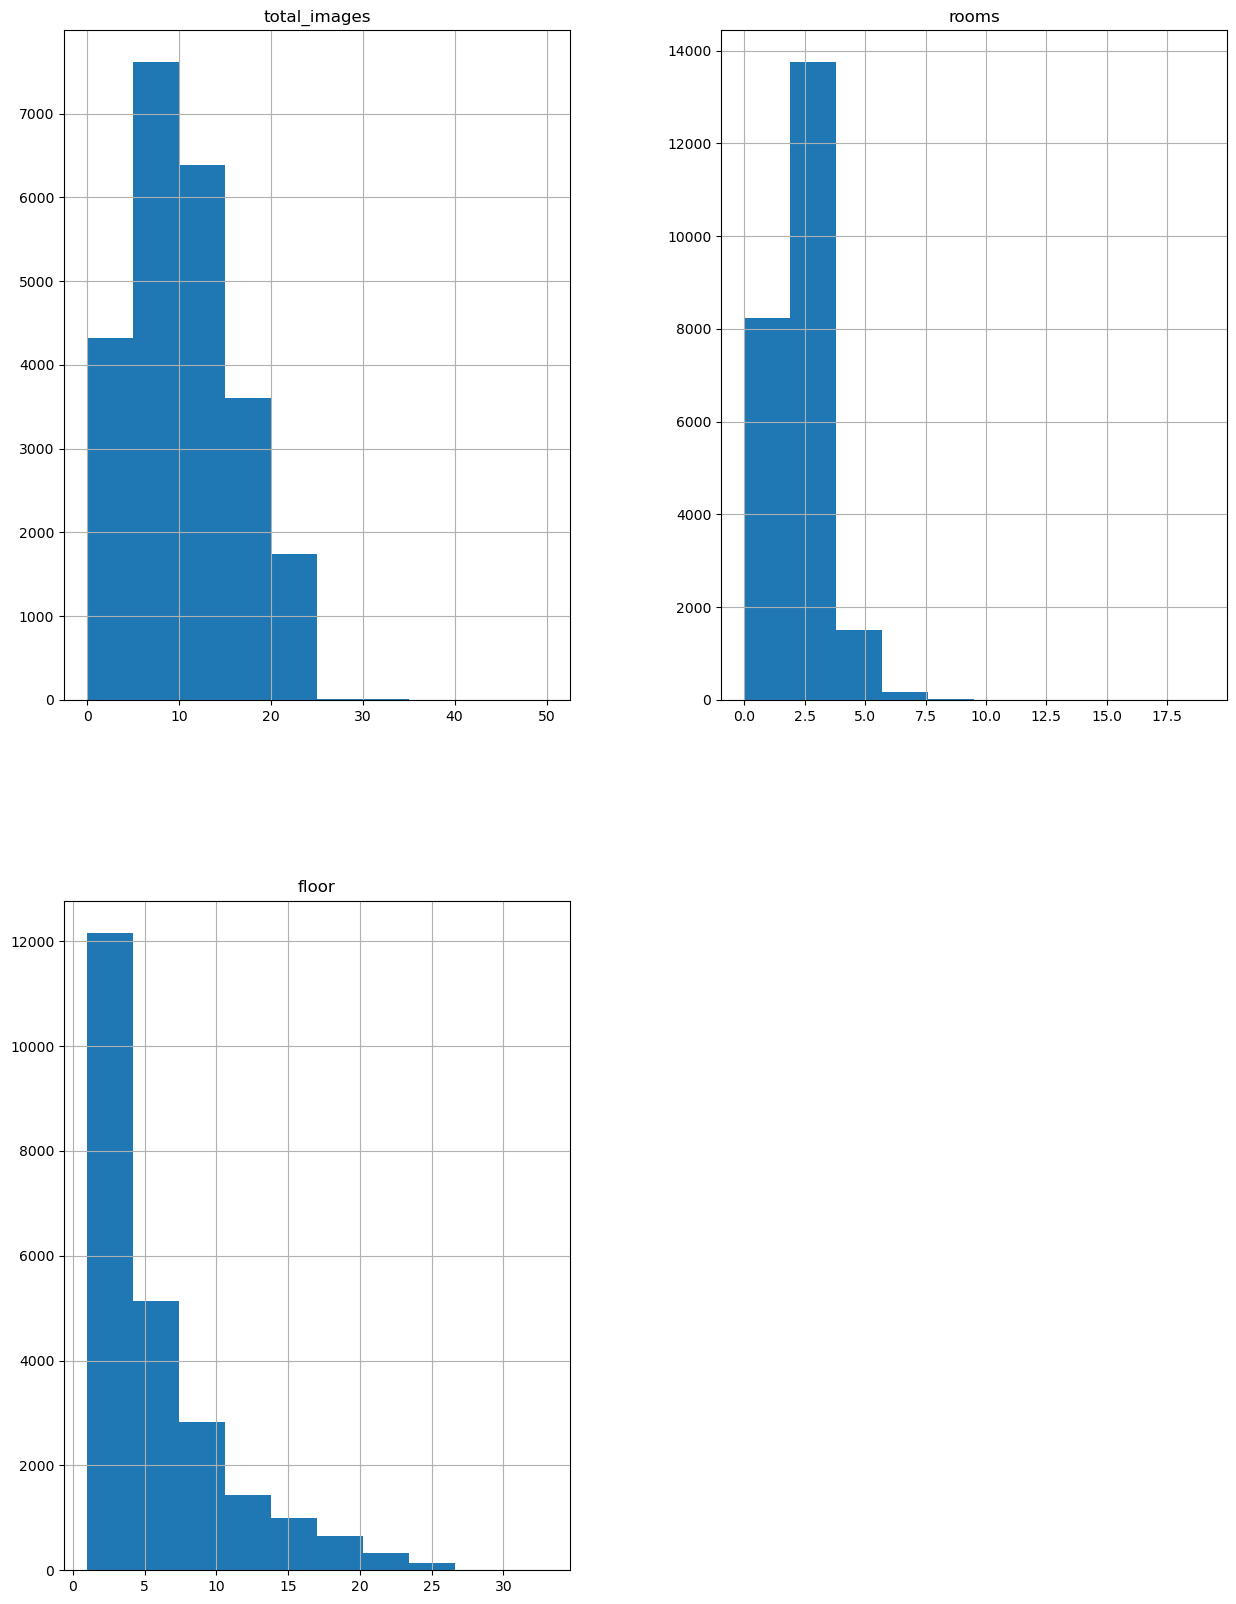

In [2]:
data = pd.read_csv('real_estate_data.csv')
#print(data.head()) нужно изменить разделители
data = pd.read_csv('real_estate_data.csv', sep='\t' , decimal=',')
print(data.head(10))
data.info()
data.hist(figsize=(15, 20))
data.describe() # очень много числовых данных записаны как строчки. Мы не сможем увидеть адекватное описание и
# гистограмму в таком варианте. Нужно привести числа записанные как строки к цифровым значениям.

### Предобработка данных

In [3]:
# заменим строчные записи цифр на числовые чтобы иметь возмжность осуществять математические операции
data['last_price'] = pd.to_numeric(data['last_price'])
data['total_area'] = pd.to_numeric(data['total_area'])
data['ceiling_height'] = pd.to_numeric(data['ceiling_height'])
data['floors_total'] = pd.to_numeric(data['floors_total'])
data['living_area'] = pd.to_numeric(data['living_area'])
data['kitchen_area'] = pd.to_numeric(data['kitchen_area'])
data['balcony'] = pd.to_numeric(data['balcony'])
data['airports_nearest'] = pd.to_numeric(data['airports_nearest'])
data['cityCenters_nearest'] = pd.to_numeric(data['cityCenters_nearest'])
data['parks_around3000'] = pd.to_numeric(data['parks_around3000'])
data['parks_nearest'] = pd.to_numeric(data['parks_nearest'])
data['ponds_around3000'] = pd.to_numeric(data['ponds_around3000'])
data['ponds_nearest'] = pd.to_numeric(data['ponds_nearest'])
data['days_exposition'] = pd.to_numeric(data['days_exposition'])
data.info() #проверяем

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  object 
 15  airports_nearest   

In [4]:
print(data.isnull().sum()) # смотрим где есть пропуски
data.value_counts('ceiling_height') #оценим какие вообще потолки указывали люди
data['ceiling_height'].sort_values(ascending=False).head(25) # есть слишком высокие для реальности потолки. Скорее всего перенесли запятую.
data.update(data[(data['ceiling_height'] >= 20) & (data['ceiling_height'] <= 100)]['ceiling_height']/10)
for t in data['ceiling_height'].unique():
    data.loc[data['ceiling_height'].isna(), 'ceiling_height'] = \
    data.loc[data['ceiling_height'] == t, 'ceiling_height'].median() # медианное значение вместо пропусков
print(data.value_counts('ceiling_height')) #проверяем. Параметр 2.7 увеличился на 9195 из зафксированных ранее пропусков
len(data[data['ceiling_height'].isna()]) # нет пропущенных данных
#data['ceiling_height'].sort_values(ascending=False).head(25) # проверка высоты потолков

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64
ceiling_height
2.70     10777
2.50      3522
2.60      1647
3.00      1112
2.80       993
         ...  
3.83         1
3.84         1
3.87         1
3.88         1
14.00        1
Length: 176, dtype: int64


0

1) Пропущены 9195 в ceiling_height. Скорее всего люди, которые живут в типовых квартирах думают что все потолки примерно одинаковые и не считают это за важный параметр. На место пропусков лучше всего будет поставить медианное значение, так как есть сильно выбивающиеся данные. Аномалии с выбивающимися значениями 20м потолок и выше лучше устранить переносом запятой. 

2) Пропущены 86 значений во floors_total, пока сложно оценить насколько это может повлиять если заменить эти данные. 86 относительно 24000 крайне малое значение. Пока пропустим это. Возможная причина пропуска - частные дома

In [5]:
data.value_counts('living_area')
living_area_median = data['living_area'].median() #посчитаем медианное значение
data['living_area'] = data['living_area'].fillna(living_area_median) #вставим значение переменной вместо Nan
print(data.value_counts('living_area')) # посмотрим распределение
len(data[data['living_area'].isna()]) # проверим нет пропущенных данных

living_area
30.00     2501
18.00      882
17.00      675
16.00      486
20.00      481
          ... 
33.03        1
32.95        1
32.84        1
32.79        1
409.70       1
Length: 1782, dtype: int64


0

3) Пропущны 1903 в living_area. Возможная причина пропуска - люди не знают точный метраж. Это существенный процент, так же заменим пропуски медианным значением.

In [6]:
data['is_apartment'].unique() # по какой то причине булевы значения сохранились как строки. Восстановим булевы значения 
data.value_counts('is_apartment')
data['is_apartment'] = data['is_apartment'].fillna('False')
data.loc[data['is_apartment'] == 'False', 'is_apartment'] = False
data.value_counts('is_apartment') # восстановиил булево значение и убрали пропуски

is_apartment
False    23649
True        50
dtype: int64

4) Почти никто не отмечал поле аппартаменты. Возможно это связано с тем, что если "Да" то ставили галочку, а если "Нет" то просто пропускали. 

In [7]:
data.value_counts('kitchen_area')
kitchen_area_median = data['kitchen_area'].median() #посчитаем медианное значение
data['kitchen_area'] = data['kitchen_area'].fillna(kitchen_area_median) #вставим значение переменной вместо Nan
print(data.value_counts('kitchen_area')) # посмотрим распределение
len(data[data['kitchen_area'].isna()]) # проверим нет пропущенных данных

kitchen_area
9.10      2360
6.00      1300
10.00     1262
8.00      1110
9.00      1101
          ... 
12.72        1
12.75        1
12.84        1
12.87        1
112.00       1
Length: 971, dtype: int64


0

5) Многие не отмечали площадь кухни. Это может быть связано с современной планировкой однокомнатных квартир и студий со свободной планировкой где кухня является частью гостинной. Заполним медианным значением. 

In [8]:
data['balcony'] = data['balcony'].fillna(0)
print(data.value_counts('balcony')) # посмотрим распределение
len(data[data['balcony'].isna()]) # проверим нет пропущенных данных

balcony
0.0    15277
1.0     4195
2.0     3659
5.0      304
4.0      183
3.0       81
dtype: int64


0

5) Не указанное количество балконов скорее всего указывает на их отсутсвие. Заменим не указанные данные на '0'. 

In [9]:
data.value_counts('locality_name') 
data['locality_name'].unique()
data['locality_name'] = data['locality_name'].str.replace('ё', 'е', regex=True) # поудаляем лишнего
data['locality_name'] = data['locality_name'].str.replace('городской поселок','поселок городского типа')
data['locality_name'] = data['locality_name'].str.replace('поселок городского типа','пгт')
data['locality_name'] = data['locality_name'].str.replace('поселок','')
data['locality_name'] = data['locality_name'].str.replace('деревня','')
data['locality_name'] = data['locality_name'].str.replace('пгт','')
data['locality_name'] = data['locality_name'].str.replace('село','')
data['locality_name'] = data['locality_name'].str.replace('коттеджный','')
data['locality_name'] = data['locality_name'].str.replace(' ','')
data = data.dropna(subset=['locality_name']) # без названия города лучше удалить данные, едва ли они помогут
data['locality_name'].unique() # проверим
data.loc[data['locality_name'] != 'Санкт-Петербург'] # получаем 15721 объявлений из СПБ, и 7929 из области


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,kitchen_area,balcony,locality_name,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
1,7,3350000.0,40.40,2018-12-04T00:00:00,1,2.7,11.0,18.60,1,False,...,11.00,2.0,Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0
5,10,2890000.0,30.40,2018-09-10T00:00:00,1,2.7,12.0,14.40,5,False,...,9.10,0.0,Янино-1,NaN,NaN,NaN,NaN,NaN,NaN,55.0
6,6,3700000.0,37.30,2017-11-02T00:00:00,1,2.7,26.0,10.60,6,False,...,14.40,1.0,Парголово,52996.0,19143.0,0.0,NaN,0.0,NaN,155.0
8,20,2900000.0,33.16,2018-05-23T00:00:00,1,2.7,27.0,15.43,26,False,...,8.81,0.0,Мурино,NaN,NaN,NaN,NaN,NaN,NaN,189.0
11,9,3300000.0,44.00,2018-08-27T00:00:00,2,2.7,5.0,31.00,4,False,...,6.00,1.0,Ломоносов,48252.0,51677.0,0.0,NaN,0.0,NaN,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23692,2,1350000.0,30.00,2017-07-07T00:00:00,1,2.7,5.0,17.50,4,False,...,6.00,0.0,Тихвин,NaN,NaN,NaN,NaN,NaN,NaN,413.0
23693,9,4600000.0,62.40,2016-08-05T00:00:00,3,2.6,9.0,40.00,8,False,...,8.00,0.0,Петергоф,45602.0,34104.0,1.0,352.0,1.0,675.0,239.0
23695,14,3100000.0,59.00,2018-01-15T00:00:00,3,2.7,5.0,38.00,4,False,...,8.50,0.0,Тосно,NaN,NaN,NaN,NaN,NaN,NaN,45.0
23696,18,2500000.0,56.70,2018-02-11T00:00:00,2,2.7,3.0,29.70,1,False,...,9.10,0.0,Рождествено,NaN,NaN,NaN,NaN,NaN,NaN,NaN


6) Часть данных о названии города в количестве 49 отсутсвует. Это скорее всего человеческий фактор. Эти данные можно пропустить. Попробуем удалить лишние слова у названий чтобы получить "корень" слова, будет не очень красиво но максимально эффектовно. 

In [10]:
data.value_counts('airports_nearest')
for t in data['locality_name'].unique():  #попробуем найти среднее расстояние в городе и заполним пустые значения по этому городу
    data.loc[(data['locality_name'] == t) & (data['airports_nearest'].isna()), 'airports_nearest'] = \
    data.loc[(data['locality_name'] == t), 'airports_nearest'].mean()
data.isnull().sum() # около 800 значений удалось получить что приятно

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               85
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         4829
cityCenters_nearest      5511
parks_around3000         5510
parks_nearest           15586
ponds_around3000         5510
ponds_nearest           14565
days_exposition          3180
dtype: int64

7) Часть данных о расстоянии до аэропорта отсуствует. Если посмотреть на данные, то видно что расстояние не определяется в названии областных населенных пунктов. Скорее всего они были внесены не точно и карты не смогли точно идентефицировать расположение и как следствие не смогли рассчитать расстояние. Мы можем сгруппировать данные по маленьким городам и на основании их среднего расстояния до аэропорта заполнить данные остальных пропущенных элементов. 

In [11]:
data['parks_around3000'] = data['parks_around3000'].fillna(0)
data['ponds_around3000'] = data['ponds_around3000'].fillna(0)
data.isnull().sum() # заменили отсутсвующие значения на ноль и проверили 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               85
living_area                 0
floor                       0
is_apartment                0
studio                      0
open_plan                   0
kitchen_area                0
balcony                     0
locality_name               0
airports_nearest         4829
cityCenters_nearest      5511
parks_around3000            0
parks_nearest           15586
ponds_around3000            0
ponds_nearest           14565
days_exposition          3180
dtype: int64

8)Отсутсвует одинаковое значение в parks_around3000 и ponds_around3000. Скорее всего это связано с тем что как правило в парках есть пруды. Вряд ли это машинная ошибка. Пропуск вероятнее всего связан с тем что их нет в этом радиусе. Заменим значения на ноль. 

In [12]:
data2 = data.copy() # создадим переменную data2 чтобы узнать природу пропусков в cityCenters_nearest
data2['cityCenters_nearest'] = data2['cityCenters_nearest'].fillna(0) # заменим Nan на 0
data2 = data2.loc[data2['cityCenters_nearest'] == 0] 
data2.loc[data2['locality_name'] != 'Санкт-Петербург'] # провели локальную индексацию по значению до центра равную 0
                                                       # и затем посмотрели в них количество таких пропусков в Санкт-Петербурге - 61
data['cityCenters_nearest'].fillna(data.groupby('locality_name')['cityCenters_nearest'].transform('mean'), inplace = True)
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].mean()) # заполним пропуски 
# cityCenters_nearest средним значением по locality_name

9) Всего объявлений из СПБ 15721, и 7929 из области. Растояние до центра не указано в 5511 случаев вобщем. Из них всего 61 случай это СПБ, все остальное это область. Получается в большинстве объявлений из области не укаазно расстояние до центра. Это 
означает что для области мы не сможем использовать этот параметр как влияющий фактор. В чем причина отсутсвия этих данных? Это может быть связано с тем что в области расстояние до центра не просили указать в программе ли его вообще не было, так как там этот фактор не так влияет на цену недвижимости. Пока пропустим эти данные

In [13]:
print(data.loc[data['locality_name'] != 'Санкт-Петербург'].isnull().sum()) # оценим пропуски в parks_nearest в области
data.loc[data['locality_name'] == 'Санкт-Петербург'].isnull().sum() # оценим пропуски в parks_nearest в СПБ

total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total              15
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest        4829
cityCenters_nearest        0
parks_around3000           0
parks_nearest           7149
ponds_around3000           0
ponds_nearest           6827
days_exposition         1097
dtype: int64


total_images               0
last_price                 0
total_area                 0
first_day_exposition       0
rooms                      0
ceiling_height             0
floors_total              70
living_area                0
floor                      0
is_apartment               0
studio                     0
open_plan                  0
kitchen_area               0
balcony                    0
locality_name              0
airports_nearest           0
cityCenters_nearest        0
parks_around3000           0
parks_nearest           8437
ponds_around3000           0
ponds_nearest           7738
days_exposition         2083
dtype: int64

10) По параметру parks_nearest. По СПБ пропущено 8437 из 15721, по области пропущено 7149 из 7929 . Это крайне высокий процент пропуска и там и там. Скорее всего данный параметр мы не сможем использовать для адекватной оценки данных по этой таблице. 

11) По параметру ponds_nearest. По СПБ пропущено 7738 из 15721, по области пропущено 6827 из 7929 . Это так же крайне высокий процент пропуска и там и там. Скорее всего данный параметр мы не сможем использовать для адекватной оценки данных по этой таблице.

Пропуски в параметрах ponds_nearest и parks_nearest могут быть связаны с тем что люди которые заполняли данные вероятно живут не рядом с парками и не знают точного расстояния,  а программа вероятно не рассчитывает автоматически расстояние. Возможно это связно с тем что доблирующий параметр со значением 3000 гораздо больше влияет на цену, а то что дальше 3 км не считвается пешей доступностью и это не влияет на цену. 

12) Пропуски в параметре days_exposition могут быть связаны с тем что объявление еще актуально. Или сбой передачи данных.

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,cityCenters_nearest,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition
count,23650.000000,2.365000e+04,23650.000000,23650.000000,23650.000000,23565.000000,23650.000000,23650.000000,23650.000000,23650.000000,18821.000000,23650.000000,23650.000000,8064.000000,23650.000000,9085.000000,20470.000000
mean,9.862326,6.541127e+06,60.329069,2.070106,2.717986,10.675875,34.091359,5.893277,10.425715,0.591712,29551.023018,14463.343220,0.469091,490.830729,0.590359,518.059879,180.753200
std,5.682278,1.089640e+07,35.661808,1.078620,0.250641,6.594823,21.169359,4.883317,5.628088,0.959662,13069.315779,7668.139601,0.748458,342.554386,0.883539,277.841733,219.777916
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,0.000000,1.000000,0.000000,13.000000,1.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,19.000000,2.000000,7.300000,0.000000,18814.000000,10939.000000,0.000000,288.000000,0.000000,293.000000,45.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.700000,9.000000,30.000000,4.000000,9.100000,0.000000,27380.000000,14463.343220,0.000000,454.500000,0.000000,502.000000,95.000000
75%,14.000000,6.799000e+06,69.700000,3.000000,2.700000,16.000000,41.037500,8.000000,11.427500,1.000000,38786.000000,15743.000000,1.000000,612.000000,1.000000,730.000000,231.000000
max,50.000000,7.630000e+08,900.000000,19.000000,14.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3.000000,3190.000000,3.000000,1344.000000,1580.000000


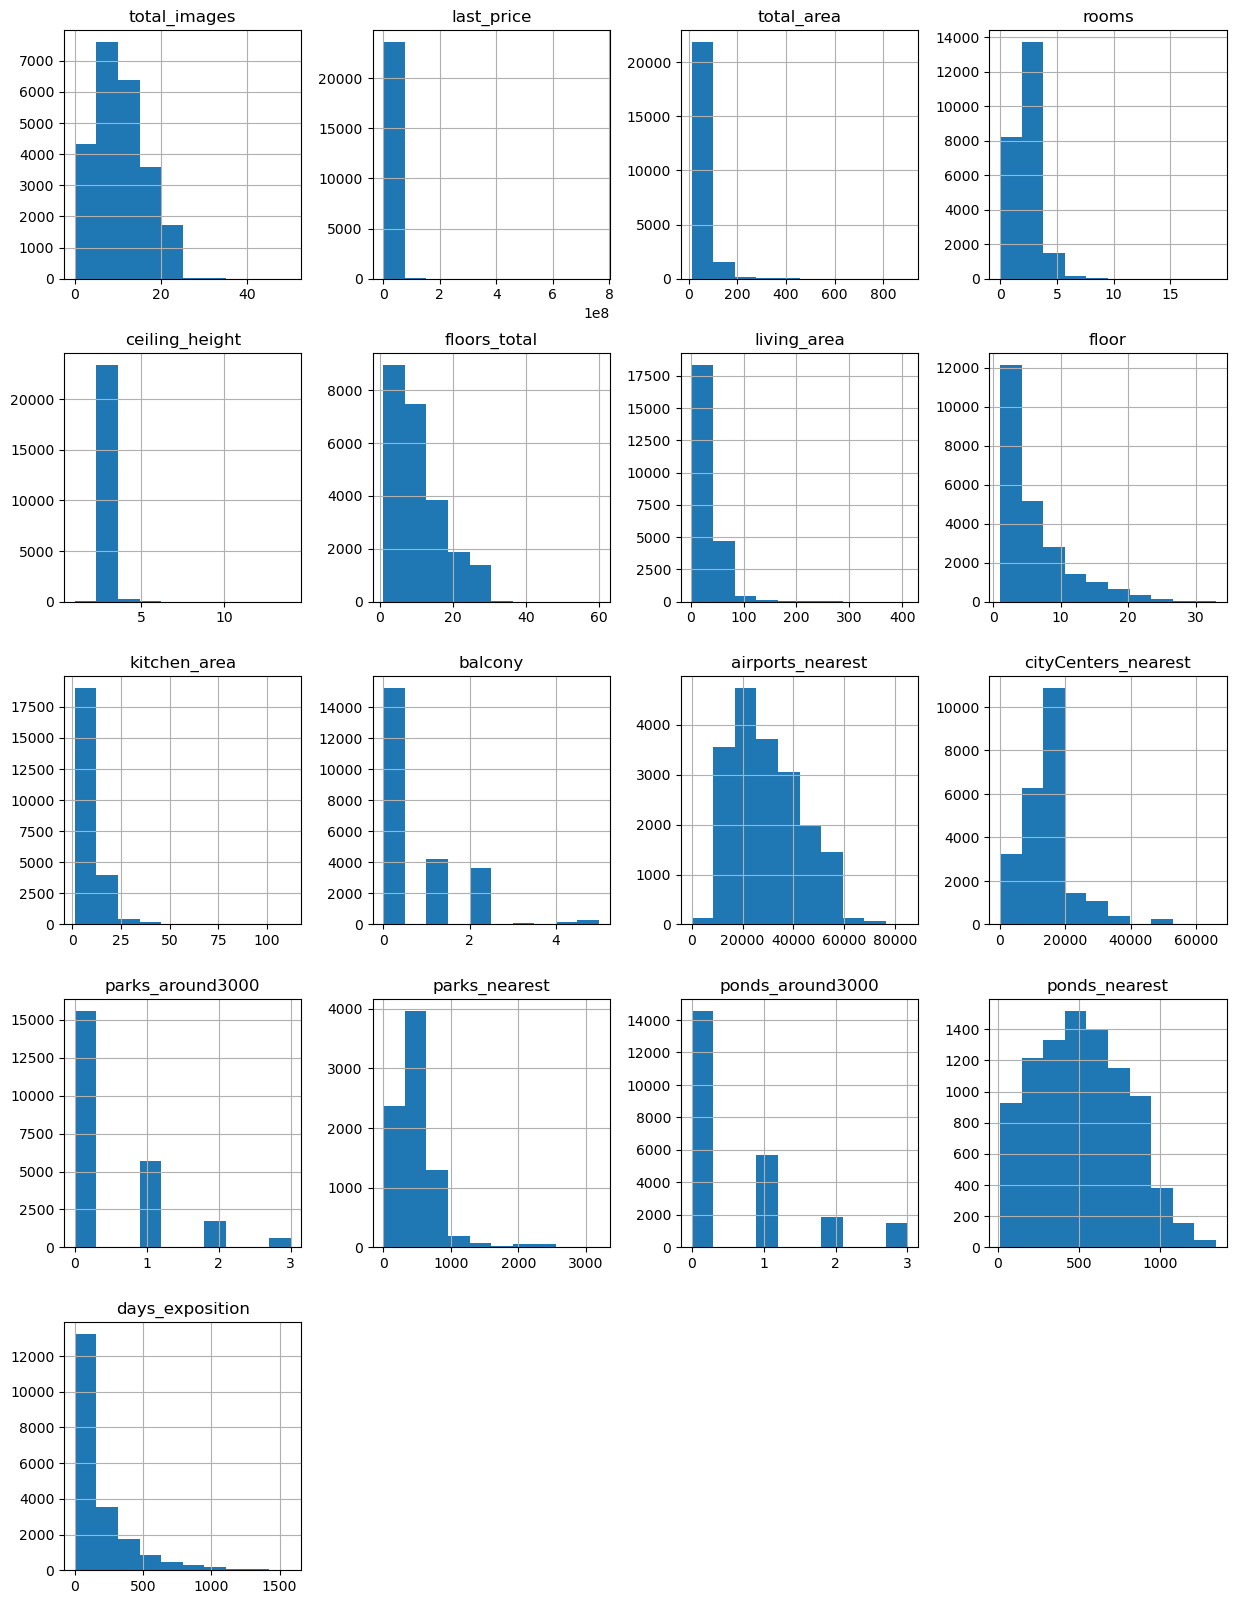

In [14]:
data.hist(figsize=(15, 20)) # посмотрим гистограмму после обрабоки данных
data.describe()

#### Промежуточный вовод по 2 части
Была проведена предобработка данных: исследованы и исправлены где это возможно неверные форматы, выбивающиеся значения, отсутствующие данные.

Теперь обработанные данные смогут дать более ясную картину чем "сырые".

### Посчитаем и добавим в таблицу новые столбцы

In [15]:
data['price_meter'] = data['last_price'] / data['total_area'] # посчитаем цену за кв метр в новый столбец
data['name_first_day_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT').dt.weekday # день недели
# в новый столбец, где 0 - понедельник. 
data['name_first_month_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT').dt.month # первый месяц
# публикации объявления
data['year_exposition'] = pd.to_datetime(data['first_day_exposition'], format = '%Y-%m-%dT').dt.year # год публикации
#  объявления
def categorize_floor(row):
    which_floor = row['floor']
    total_floor = row['floors_total']
    if which_floor == 1:
        return 'первый'
    if which_floor == total_floor:
        return 'последний'
    return 'другой'
floor_category = data.apply(categorize_floor, axis = 1) # создаем функцию для категоризаци этажей
data['floor_category'] = floor_category # и переносим значения в новый столбец
data['cityCenters_nearest'] = data['cityCenters_nearest'] / 1000
data['cityCenters_nearest'] = data['cityCenters_nearest'].astype('int64') # переведем метры в километры и в целые значения


#### Промежуточный вовод по 3 части
Были добавлены несколько столбцов которые помогут для анализа и вывода.

### Проведем исследовательский анализ данных

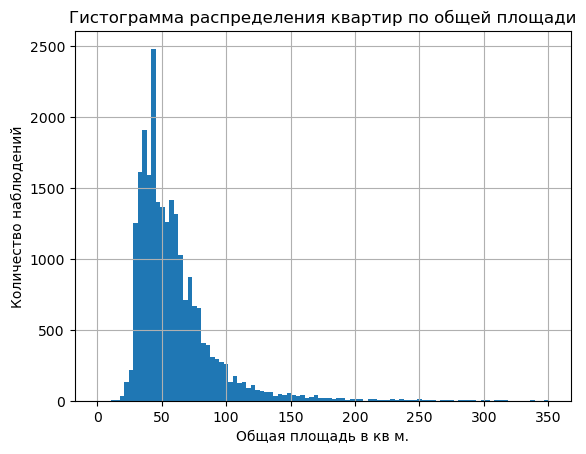

In [16]:
data['total_area'].hist(bins=100,range=(0,350))
plt.xlabel('Общая площадь в кв м.')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения квартир по общей площади')
plt.show()

Из гистограммы общей жилой площади можно сделать вывод, что больше всего квартир с площадью около 40 кв м

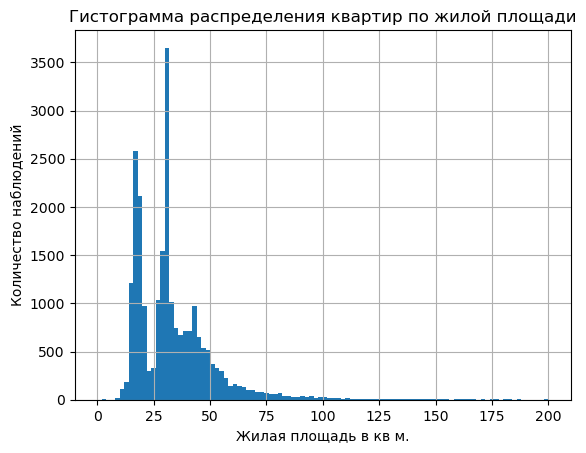

In [17]:
data['living_area'].hist(bins=100,range=(0,200))
plt.xlabel('Жилая площадь в кв м.')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения квартир по жилой площади')
plt.show()

Из гистограммы жилой площади можно сделать вывод, что больше всего квартир с площадью около 30 кв м

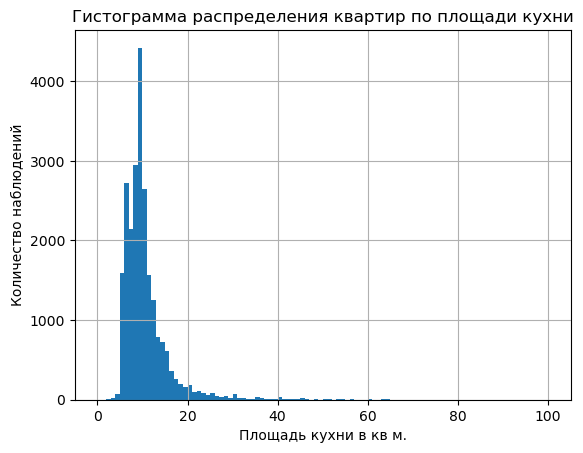

In [18]:
data['kitchen_area'].hist(bins=100,range=(0,100))
plt.xlabel('Площадь кухни в кв м.')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения квартир по площади кухни')
plt.show()

Из гистограммы площади кухни можно сделать вывод, что больше всего квартир с площадью около 10 кв м

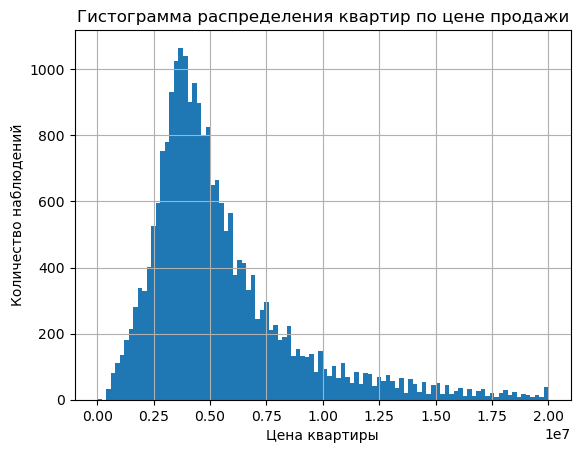

In [19]:
data['last_price'].hist(bins=100,range=(0,20000000))
plt.xlabel('Цена квартиры')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения квартир по цене продажи')
plt.show()

Из гистограммы цены объекта можно сделать вывод, что больше всего квартир с ценой 3.5 млн

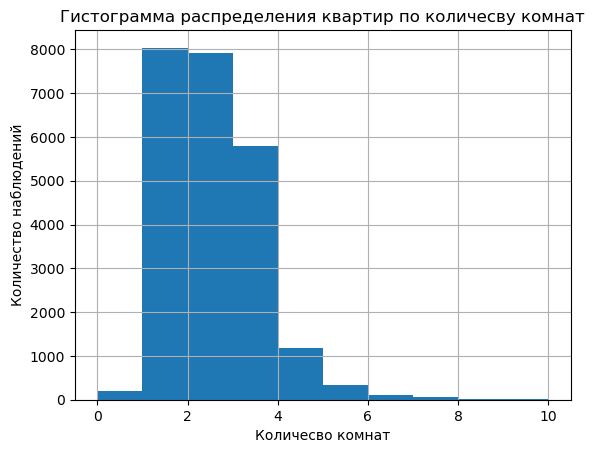

In [20]:
data['rooms'].hist(bins=10,range=(0,10))
plt.xlabel('Количесво комнат')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения квартир по количесву комнат')
plt.show()

Из гистограммы количества комнат можно сделать вывод, что больше всего квартир с 1 и 2 комнатами

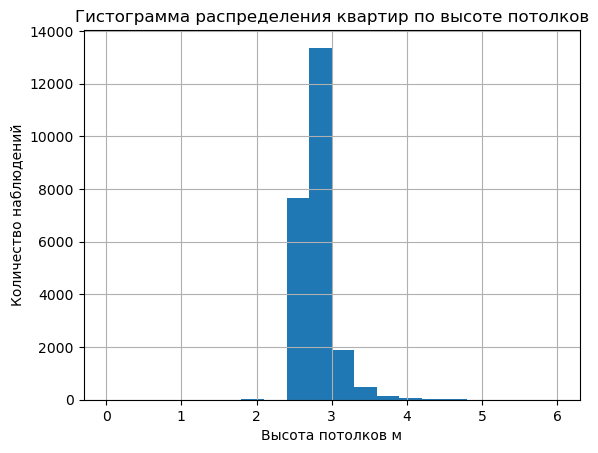

In [21]:
data['ceiling_height'].hist(bins=20,range=(0,6))
plt.xlabel('Высота потолков м')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения квартир по высоте потолков')
plt.show()

Из гистограммы высоты потолков можно сделать вывод, что больше всего квартир с высотой 2.7 метра

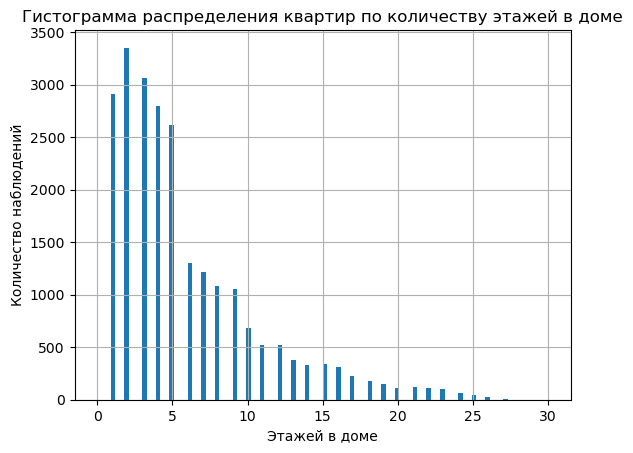

In [22]:
data['floor'].hist(bins=100,range=(0,30))
plt.xlabel('Этажей в доме')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения квартир по количеству этажей в доме')
plt.show()

Из гистограммы этажа квартиры можно сделать вывод, что больше всего квартир находятся на 1-5 этажах. 

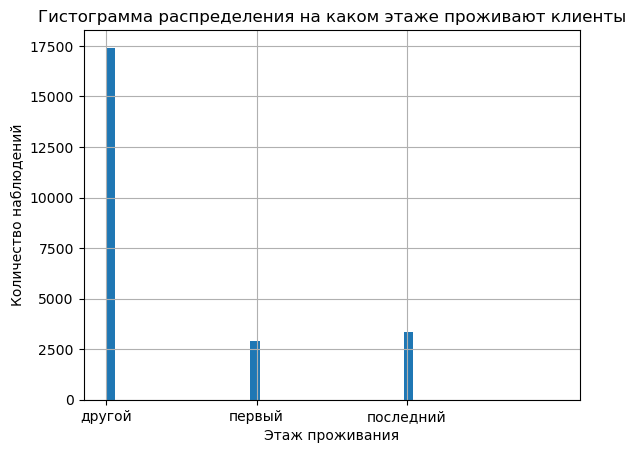

In [23]:
data['floor_category'].hist(bins=50,range=(0,3))
plt.xlabel('Этаж проживания')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения на каком этаже проживают клиенты')
plt.show()

Из гистограммы типа этажа квартиры можно сделать вывод, что больше всего квартир находятся в категории "другой" этаж.

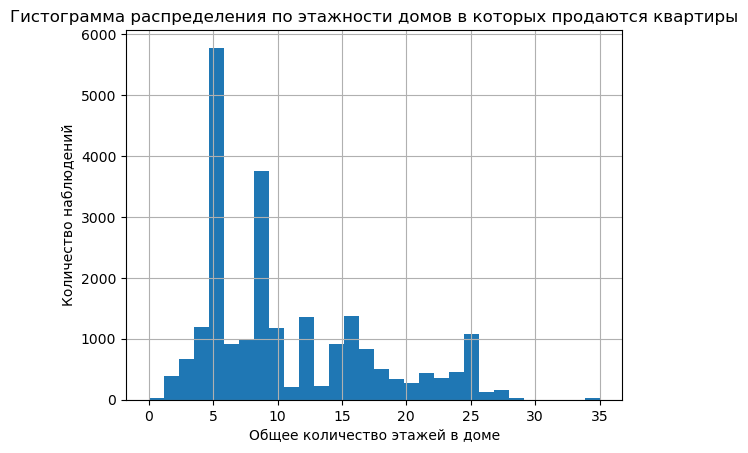

In [24]:
data['floors_total'].hist(bins=30,range=(0,35))
plt.xlabel('Общее количество этажей в доме')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения по этажности домов в которых продаются квартиры')
plt.show()

Из гистограммы общего количества этажей в доме можно сделать вывод, что больше всего квартир находятся в 5ти этажных домах.

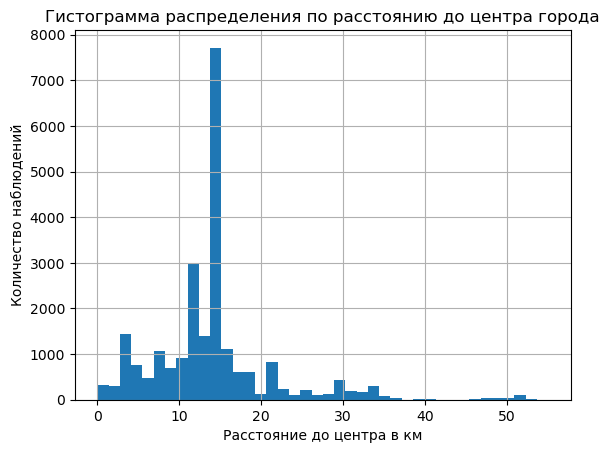

In [25]:
data['cityCenters_nearest'].hist(bins=40,range=(0,55))
plt.xlabel('Расстояние до центра в км')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения по расстоянию до центра города')
plt.show()

Из гистограммы расстояние до центра города можно сделать вывод, что больше всего квартир находятся на расстоянии 14000 метров от центра.

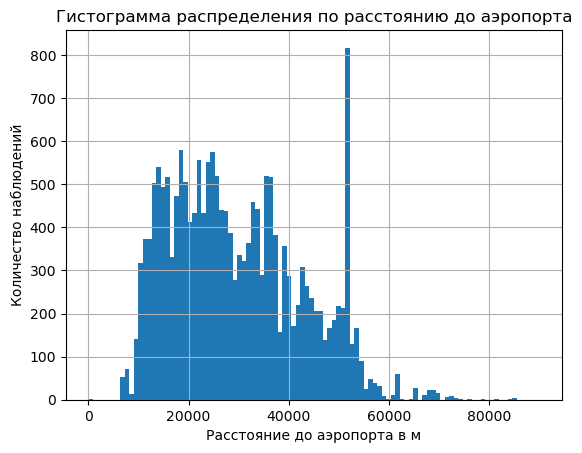

In [26]:
data['airports_nearest'].hist(bins=100,range=(0,90000))
plt.xlabel('Расстояние до аэропорта в м')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения по расстоянию до аэропорта')
plt.show()

Из гистограммы расстояния до ближайшего аэропорта можно сделать вывод, что больше всего квартир находятся на расстоянии 50000 метров от аэропорта.

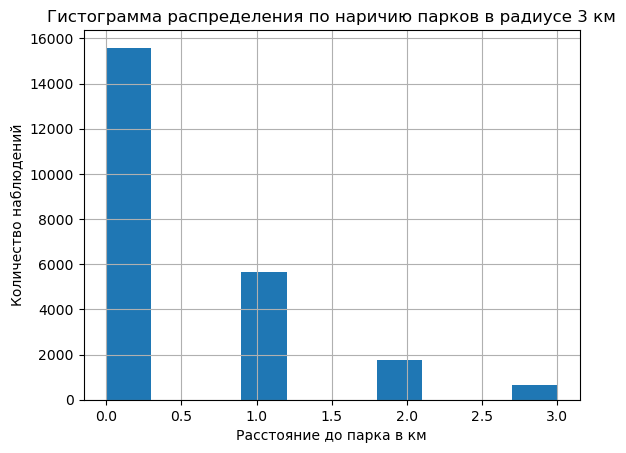

In [27]:
data['parks_around3000'].hist(bins=10,range=(0,3))
plt.xlabel('Расстояние до парка в км')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения по наричию парков в радиусе 3 км')
plt.show()

Из гистограммы расстояния до ближайшего парка можно сделать вывод, что больше всего квартир находятся в пределах 250 метров от парка.

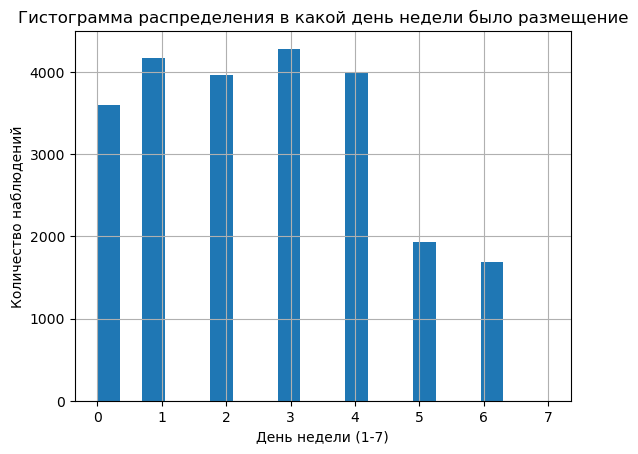

In [28]:
data['name_first_day_exposition'].hist(bins=20,range=(0,7))
plt.xlabel('День недели (1-7)')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения в какой день недели было размещение')
plt.show()

Из гистограммы дня публикации объявления можно сделать вывод, что больше всего квартир были опубликованы в будние дни с понедельника по пятницу включительно.

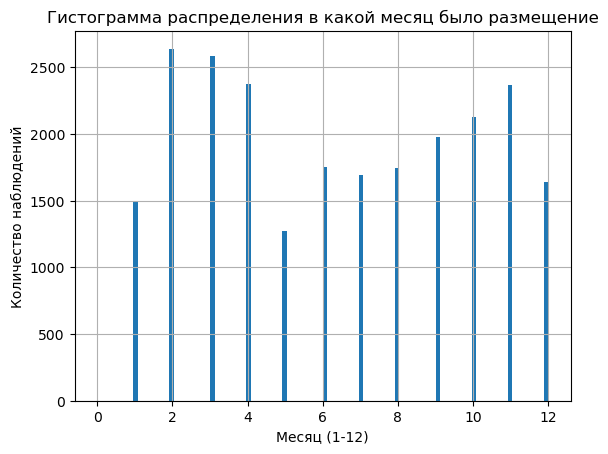

In [29]:
data['name_first_month_exposition'].hist(bins=100,range=(0,12))
plt.xlabel('Месяц (1-12)')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения в какой месяц было размещение')
plt.show()

Из гистограммы месяца публикации объявления можно сделать вывод, что больше всего квартир были опубликованы в 2 пика - февраль, март, апрель, а так же сентябрь, октябрь, ноябрь. 

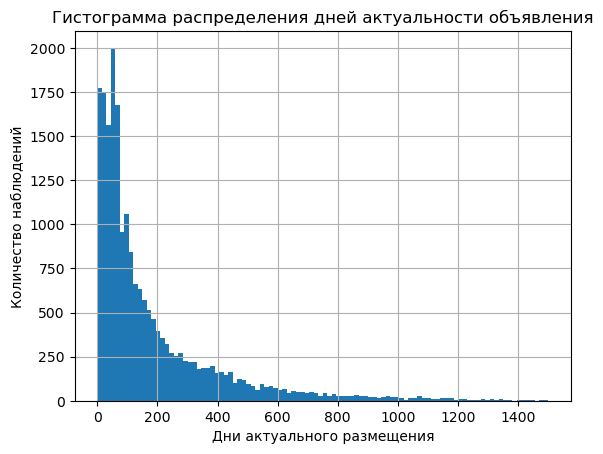

mean      180.7532
median     95.0000
Name: days_exposition, dtype: float64

In [30]:
data['days_exposition'].hist(bins=100,range=(0,1500))
plt.xlabel('Дни актуального размещения')
plt.ylabel('Количество наблюдений')
plt.title('Гистограмма распределения дней актуальности объявления')
plt.show()
data['days_exposition'].agg(['mean', 'median'])

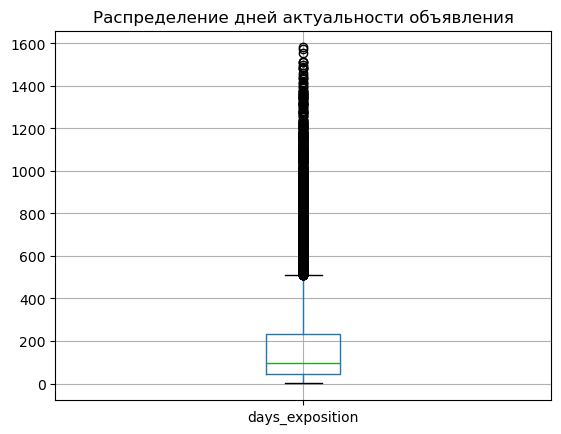

In [31]:
data.boxplot('days_exposition')
plt.title('Распределение дней актуальности объявления')
plt.show()

#### Промежуточный вовод по 4 части
1. Из построенных выше графиков можно сделать вывод что медианное значение точно отражает что чаще всего квартиры продаются за 95 дней.

Быстрыми можно назвать продажи до 210 дней если смотреть на график "с усами". Или в рамках 180 дней отталкиваясь от среднего значения.

От 500 дней можно считать продажи необычайно долгими. 

In [32]:
print(data['days_exposition'].describe()) # посмотрим численное описание усатого графика
data.query('days_exposition > 500') # 1744 объявления свыше 500 дней размещения \
#\ посмотрим есть ли что то особенное в объявлениях свыше 500 дней. Явных проблем не вижу

count    20470.000000
mean       180.753200
std        219.777916
min          1.000000
25%         45.000000
50%         95.000000
75%        231.000000
max       1580.000000
Name: days_exposition, dtype: float64


,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,...,parks_around3000,parks_nearest,ponds_around3000,ponds_nearest,days_exposition,price_meter,name_first_day_exposition,name_first_month_exposition,year_exposition,floor_category
2,10,5196000.0,56.00,2015-08-20T00:00:00,2,2.70,5.0,34.3,4,False,...,1.0,90.0,2.0,574.0,558.0,92785.714286,3,8,2015,другой
17,6,4180000.0,36.00,2016-09-09T00:00:00,1,2.70,17.0,16.5,7,False,...,0.0,NaN,1.0,859.0,571.0,116111.111111,4,9,2016,другой
23,11,2950000.0,32.00,2016-10-29T00:00:00,1,2.60,9.0,17.7,9,False,...,2.0,517.0,1.0,190.0,615.0,92187.500000,5,10,2016,последний
35,6,15500000.0,149.00,2017-06-26T00:00:00,5,2.70,5.0,104.0,4,False,...,0.0,NaN,1.0,779.0,644.0,104026.845638,0,6,2017,другой
42,13,22000000.0,161.80,2015-07-08T00:00:00,4,2.80,4.0,80.9,2,False,...,2.0,47.0,1.0,907.0,987.0,135970.333745,2,7,2015,другой
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23664,5,9000000.0,110.00,2015-12-10T00:00:00,4,3.36,7.0,64.6,5,False,...,3.0,417.0,1.0,118.0,816.0,81818.181818,3,12,2015,другой
23672,5,3000000.0,30.80,2016-06-08T00:00:00,1,2.70,5.0,16.1,3,False,...,2.0,258.0,0.0,NaN,808.0,97402.597403,2,6,2016,другой
23675,8,3550000.0,39.50,2016-10-03T00:00:00,1,2.70,16.0,19.0,13,False,...,0.0,NaN,0.0,NaN,721.0,89873.417722,0,10,2016,другой
23691,11,9470000.0,72.90,2016-10-13T00:00:00,2,2.75,25.0,40.3,7,False,...,0.0,NaN,1.0,806.0,519.0,129903.978052,3,10,2016,другой


Значения, которые отсёк верхний «ус» находящийся на отметки 500 дней и выше - это выбросы. По гистограмме видно что они выбивающиеся и редкие.

Видно, насколько медиана не стремится к длинному хвосту высоких значений. 
Среднее значение 180 дней, медиана 95 дней, количество наблюдений в выборке 20470 значений и разброс в 219 дней.

Выбросы составляют 8.5% для этого параметра и могут быть связаны с тем, что на рынке были более интересные предложения, а продавец был не заинтересован в снижении цены. То что на рынке 10% объявлений и выше имеют цену выше рынка - обычное явление. 

0.7177403156668892


0.6571875752588268

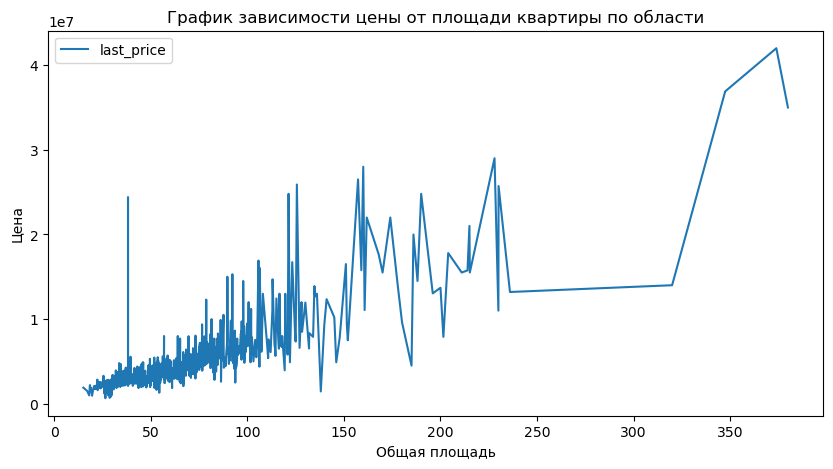

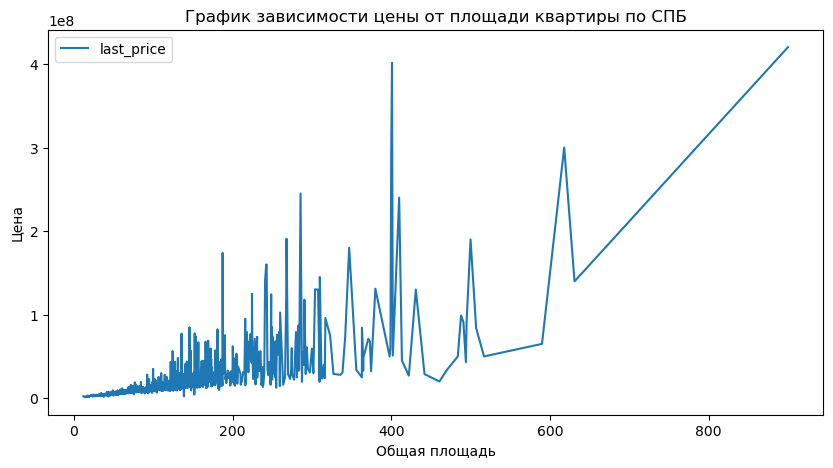

In [33]:
data.query('locality_name != "Санкт-Петербург"').pivot_table(index = 'total_area', values = 'last_price').plot(figsize=(10,5),xlabel='Общая площадь',ylabel='Цена',title='График зависимости цены от площади квартиры по области')
data.query('locality_name == "Санкт-Петербург"').pivot_table(index = 'total_area', values = 'last_price').plot(figsize=(10,5),xlabel='Общая площадь',ylabel='Цена',title='График зависимости цены от площади квартиры по СПБ')
print(data.query('locality_name != "Санкт-Петербург"')['total_area'].corr(data['last_price'])) # коэффициент Пирсона для области
data.query('locality_name == "Санкт-Петербург"')['total_area'].corr(data['last_price']) # коэффициент Пирсона для СПБ

Рынки СПБ и области скорее всего отличаются, поэтому было бы правильнее разделить их оценки.

Мы построили 2 графика зависимости цены от площади квартиры по СПБ и области. 

Коэффициент корреляции Пирсона показывает что зависимость цены от общей площади есть в области она выше чем в СПБ. 
Это может говорить о том что в СПБ другие факторы оказывают выше влияние на цену чем в области. 

0.5603209270497818


0.5436975685818674

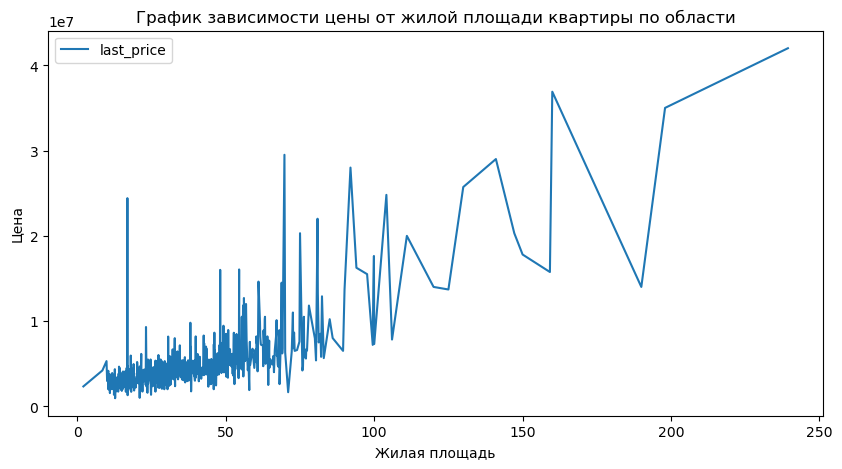

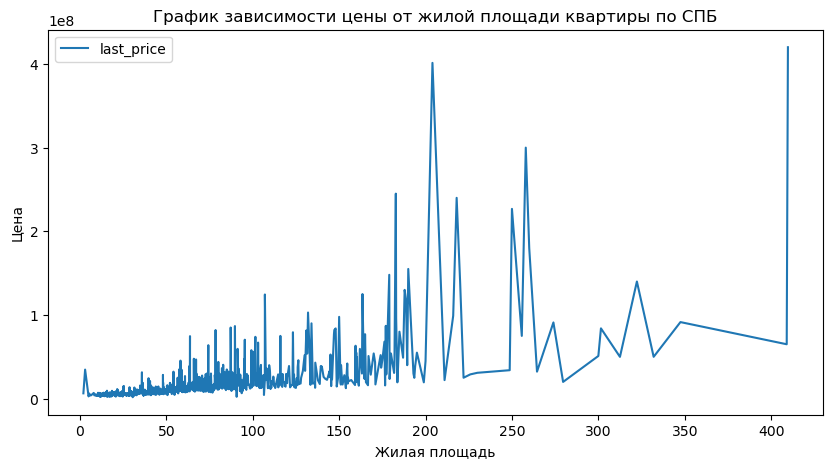

In [34]:
data.query('locality_name != "Санкт-Петербург"').pivot_table(index = 'living_area', values = 'last_price').plot(figsize=(10,5),xlabel='Жилая площадь',ylabel='Цена',title='График зависимости цены от жилой площади квартиры по области')
data.query('locality_name == "Санкт-Петербург"').pivot_table(index = 'living_area', values = 'last_price').plot(figsize=(10,5),xlabel='Жилая площадь',ylabel='Цена',title='График зависимости цены от жилой площади квартиры по СПБ')
print(data.query('locality_name != "Санкт-Петербург"')['living_area'].corr(data['last_price'])) # коэффициент Пирсона для области
data.query('locality_name == "Санкт-Петербург"')['living_area'].corr(data['last_price']) # коэффициент Пирсона для СПБ

Мы построили 2 графика зависимости цены от жилой площади квартиры по СПБ и области.

Коэффициент корреляции Пирсона показывает что зависимость цены от жилой площади есть в обоих случаях он почти одинаковый.

0.5464846896106752


0.43916959942478

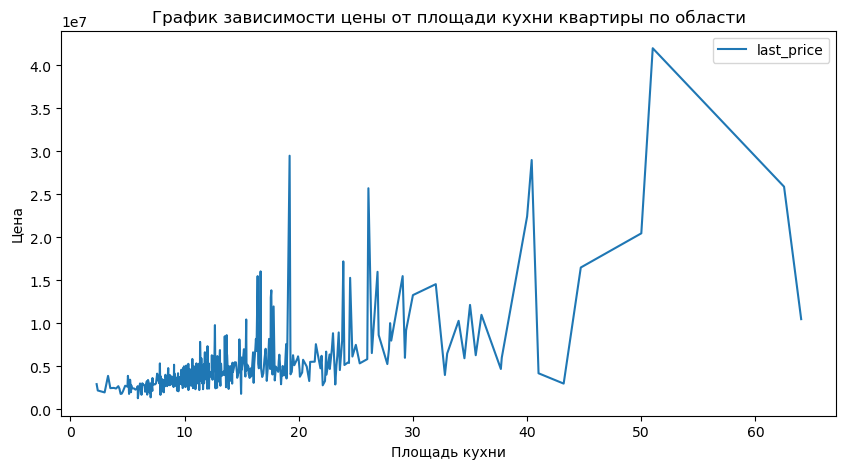

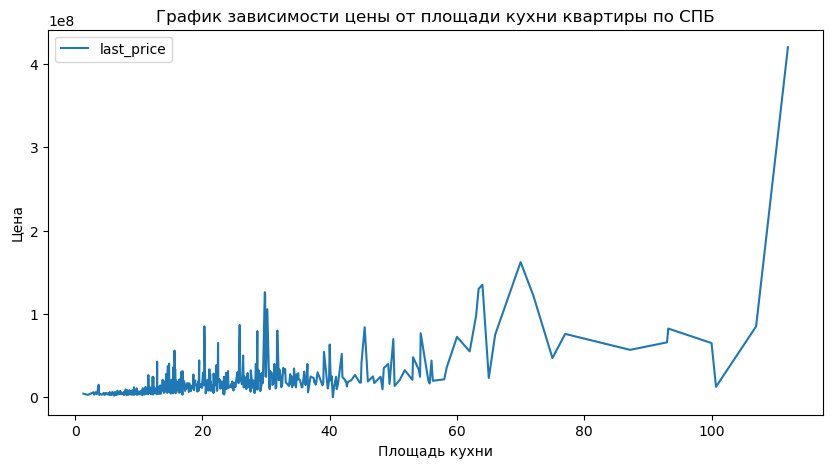

In [35]:
data.query('locality_name != "Санкт-Петербург"').pivot_table(index = 'kitchen_area', values = 'last_price').plot(figsize=(10,5),xlabel='Площадь кухни',ylabel='Цена',title='График зависимости цены от площади кухни квартиры по области')
data.query('locality_name == "Санкт-Петербург"').pivot_table(index = 'kitchen_area', values = 'last_price').plot(figsize=(10,5),xlabel='Площадь кухни',ylabel='Цена',title='График зависимости цены от площади кухни квартиры по СПБ')
print(data.query('locality_name != "Санкт-Петербург"')['kitchen_area'].corr(data['last_price'])) # коэффициент Пирсона для области
data.query('locality_name == "Санкт-Петербург"')['kitchen_area'].corr(data['last_price']) # коэффициент Пирсона для СПБ

Мы построили 2 графика зависимости цены от площади кухни квартиры по СПБ и области.

Коэффициент корреляции Пирсона показывает что зависимость цены от площади кухни есть в области она выше чем в СПБ. Это может говорить о том что в СПБ другие факторы оказывают выше влияние на цену чем в области или сильным отклонением в после 70 метров.

0.4115629073300009


0.37237533826763325

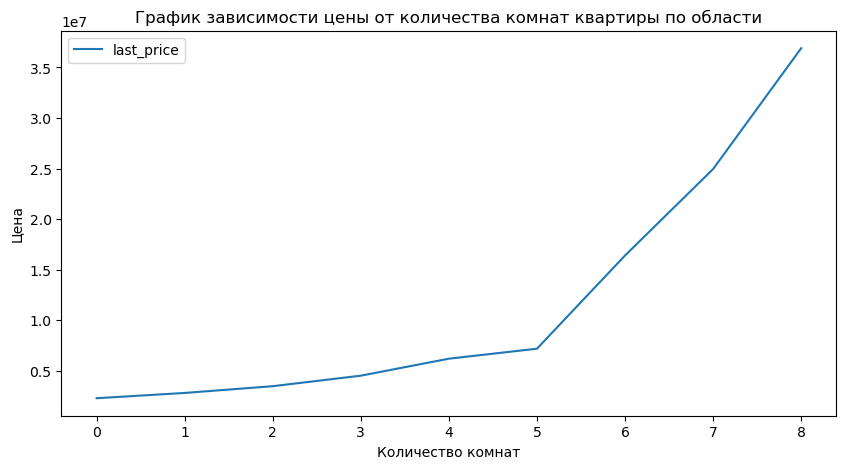

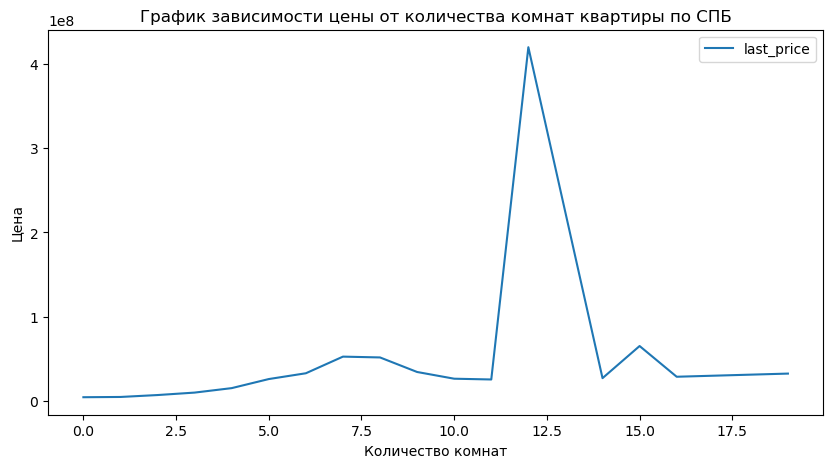

In [36]:
data.query('locality_name != "Санкт-Петербург"').pivot_table(index = 'rooms', values = 'last_price').plot(figsize=(10,5),xlabel='Количество комнат',ylabel='Цена',title='График зависимости цены от количества комнат квартиры по области')
data.query('locality_name == "Санкт-Петербург"').pivot_table(index = 'rooms', values = 'last_price').plot(figsize=(10,5),xlabel='Количество комнат',ylabel='Цена',title='График зависимости цены от количества комнат квартиры по СПБ')
print(data.query('locality_name != "Санкт-Петербург"')['rooms'].corr(data['last_price'])) # коэффициент Пирсона для области
data.query('locality_name == "Санкт-Петербург"')['rooms'].corr(data['last_price']) # коэффициент Пирсона для области

Мы построили 2 графика зависимости цены от количества комнат квартиры по СПБ и области.

Коэффициент корреляции Пирсона показывает что зависимость цены от количества комнат есть в области она выше чем в СПБ. Это может говорить о том что в СПБ другие факторы оказывают выше влияние на цену чем в области.

0.026770434775958155

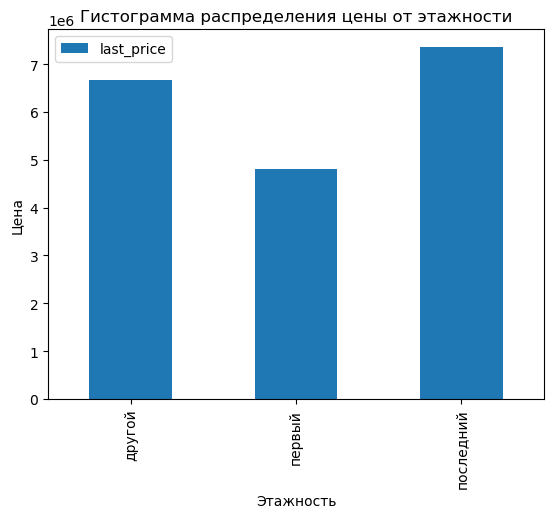

In [37]:
data.pivot_table(index = 'floor_category', values = 'last_price').plot(kind='bar',xlabel='Этажность',ylabel='Цена',title='Гистограмма распределения цены от этажности')
data['floor'].corr(data['last_price'])

По графику видно, что этажность не влияет линейно на цену. На разных этажах встречаются разные цены. Коэффециент Пирсона так же подтверждает это. 

0.0016068614793023988

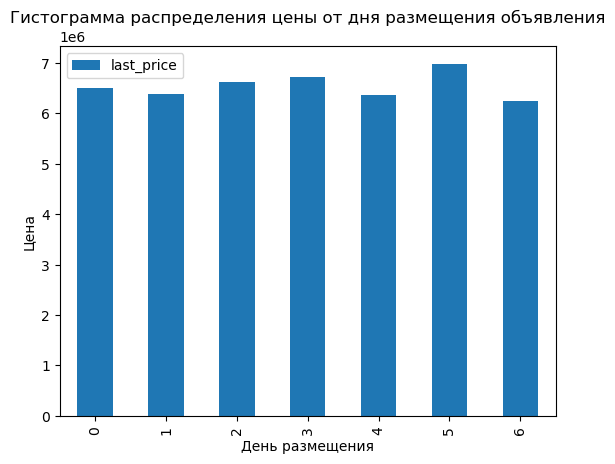

In [38]:
data.pivot_table(index = 'name_first_day_exposition', values = 'last_price').plot(kind='bar',xlabel='День размещения',ylabel='Цена',title='Гистограмма распределения цены от дня размещения объявления')
data['name_first_day_exposition'].corr(data['last_price'])

По графику видно, что день размещения не влияет линейно на цену. В разные дни объявления встречаются разные цены. Коэффециент Пирсона так же подтверждает это.

0.0027410294199242033

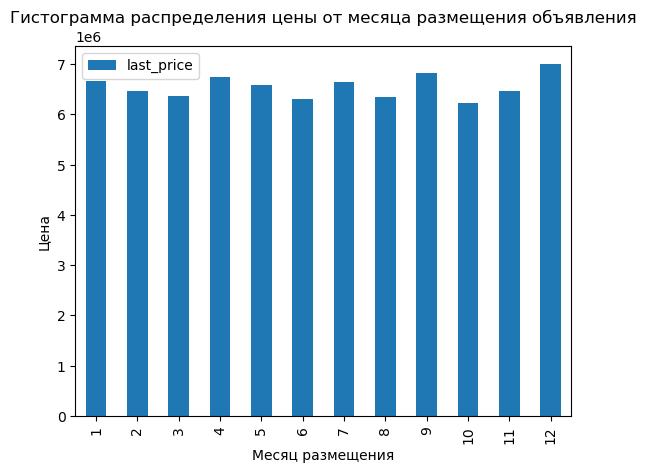

In [39]:
data.pivot_table(index = 'name_first_month_exposition', values = 'last_price').plot(kind='bar',xlabel='Месяц размещения',ylabel='Цена',title='Гистограмма распределения цены от месяца размещения объявления')
data['name_first_month_exposition'].corr(data['last_price'])

По графику видно, что месяц размещения не влияет линейно на цену. В разные месяцы объявления встречаются разные цены. Коэффециент Пирсона так же подтверждает это.

-0.04292705107682983

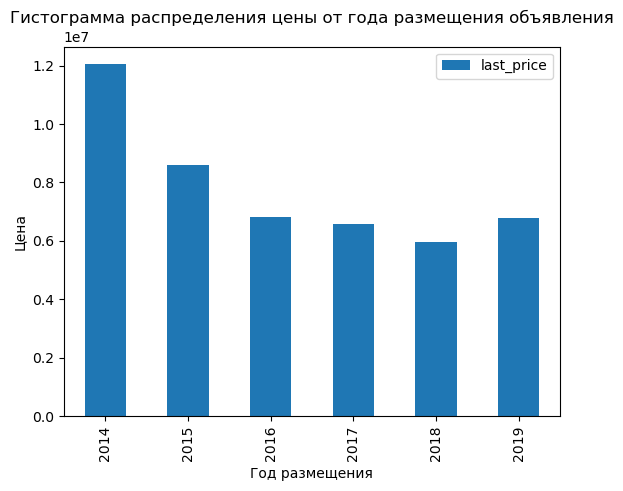

In [40]:
data.pivot_table(index = 'year_exposition', values = 'last_price').plot(kind='bar',xlabel='Год размещения',ylabel='Цена',title='Гистограмма распределения цены от года размещения объявления')
data['year_exposition'].corr(data['last_price'])

По графику видно, что год размещения не влияет линейно на цену. В разные годы объявления встречаются разные цены. Коэффециент Пирсона так же подтверждает это.

#### Промежуточный вовод по 4 части
2. Была проведена оценка зависимости цени недвижимости от:
- общей площади;
- жилой площади;
- площади кухни;
- количество комнат;
- типа этажа, на котором расположена квартира (первый, последний, другой);
- даты размещения (день недели, месяц, год).

С помощью коэффециента Пирсона мы может утверждать что чем выше общая площадь, жилая площадь, площадь кухни, количество комнат - тем выше цена недвижимости.

*зависимость наиболее очевидна в объектах с меньшей площадью. Чем крупнее объект, тем менее линейной зависимость становится. 

Этаж и даты размещения не оказывают существенное влияние на цену недвижимости. 



In [41]:
data.pivot_table(index = 'locality_name', values = 'price_meter', aggfunc = ('count','mean')) \
.sort_values(by = 'count', ascending = False).head(10)

,count,mean
locality_name,,
Санкт-Петербург,15721,114849.008794
Мурино,590,86087.512050
Кудрово,472,95324.930544
Шушары,440,78677.364217
Всеволожск,398,68654.473986
Пушкин,369,103125.819291
Колпино,338,75424.579098
Парголово,327,90175.913458
Гатчина,307,68746.146763


Выделили населённые пункты с самой высокой и низкой стоимостью квадратного метра. Максимальная цена из них в Санкт-Петербург с ценой 114849 за кв м, а в Выборге минимальная с ценой 58141 за кв м. 

In [42]:
print(data.query('locality_name == "Санкт-Петербург"')['cityCenters_nearest'].corr(data['price_meter']))
data.query('locality_name == "Санкт-Петербург"').pivot_table(index = 'cityCenters_nearest', values = 'price_meter', aggfunc = 'mean')

-0.311095482804585


,price_meter
cityCenters_nearest,
0,187324.130319
1,166603.755531
2,146662.860056
3,129416.344615
4,137475.497055
5,146979.232519
6,152277.893519
7,141399.731456
8,120581.349830


По таблице распределения расстояния в километрах до центра СПБ и цены за квадратный метр видно, что чем ближе к центру тем выше цена за квадратный метр.

Так же коэффециент Пирсона показывает что есть зависимость цены от расстояния до центра.

Наиболее линейна зависимость до 16 км до центра. Квартиры которые находятся дальше менее зависимы от этого параметра. 

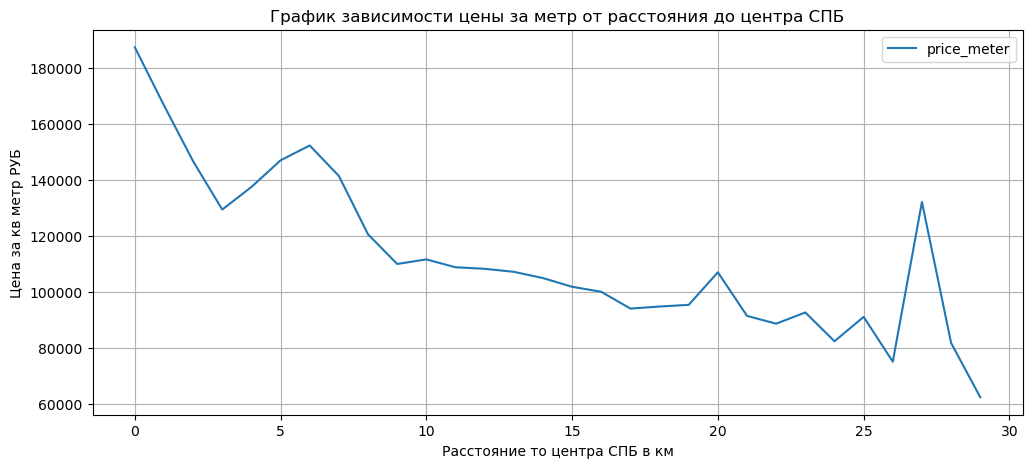

In [43]:
data.query('locality_name == "Санкт-Петербург"') \
.pivot_table(index = 'cityCenters_nearest', values = 'price_meter', aggfunc = 'mean') \
.plot(grid=True, figsize=(12,5),xlabel='Расстояние то центра СПБ в км',ylabel='Цена за кв метр РУБ',title='График зависимости цены за метр от расстояния до центра СПБ')
plt.show()

По графику распределения расстояния в километрах до центра СПБ и цены за квадратный метр видно, что чем ближе к центру тем выше цена за квадратный метр.

### Общий вывод

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений за несколько лет о продаже квартир в Санкт-Петербурге и соседних населённых пунктах.

Стояла задача — выполнить предобработку данных и изучить их, чтобы найти интересные особенности и зависимости, которые существуют на рынке недвижимости.

1. Была проведена предобработка данных: исследованы и исправлены где это возможно неверные форматы, выбивающиеся значения, отсутствующие данные.
2. Были добавлены несколько столбцов которые помогли для анализа и проверки гипотиз.
3. Мы получили следующую информацию из предоставленных данных:
 - больше всего квартир с площадью около 40 кв м
 - больше всего квартир с жилой площадью около 30 кв м
 - больше всего квартир с площадью кухни около 10 кв м
 - больше всего квартир с ценой 3.5 млн руб
 - больше всего квартир с 1 и 2 комнатами
 - больше всего квартир с высотой потолка 2.7 метра
 - больше всего квартир находятся на 1-5 этажах
 - больше всего квартир находятся в 5ти этажных домах
 - больше всего квартир находятся на расстоянии 14000 метров от центра
 - больше всего квартир находятся на расстоянии 50000 метров от аэропорта
 - больше всего квартир находятся в пределах 250 метров от парка
 - больше всего квартир были опубликованы в будние дни с понедельника по пятницу включительно
 - больше всего квартир были опубликованы в 2 пика - февраль, март, апрель, а так же сентябрь, октябрь, ноябрь
4. А) Далее было проведено исследование как быстро продаются квартиры.

 Итог: мы выяснили что чаще всего квартиры продаются за 95 дней. Быстрыми можно назвать продажи до 180 дней. От 500 дней можно считать продажи необычайно долгими. 
 
 Выбросы (то что свыше 500 дней) составляют 8.5% для этого параметра и могут быть связаны с тем, что на рынке были более интересные предложения, а продавец был не заинтересован в снижении цены. То что на рынке 10% объявлений и выше имеют цену выше рынка - обычное явление.
   
   Б) Была проведена оценка гипотизы о зависимости цены недвижимости от:
 - общей площади;
 - жилой площади;
 - площади кухни;
 - количество комнат;
 - типа этажа, на котором расположена квартира (первый, последний, другой);
 - даты размещения (день недели, месяц, год).
   
   Итог: С помощью коэффециента Пирсона мы может утверждать что чем выше общая площадь, жилая площадь, площадь кухни, количество комнат - тем выше цена недвижимости.
   
   *зависимость наиболее очевидна в объектах с меньшей площадью. Чем крупнее объект, тем менее линейной зависимость становится.

   Этаж и даты размещения не оказывают прямого влияние на цену недвижимости. Это видно по графикам и коэффециенту Пирсона
   
   С) Выделили топ 10 населённых пунктов по количеству объявлений. Максимальная цена из них в Санкт-Петербурге с ценой 114849 руб за кв м, а в Выборге минимальная с ценой 58141 руб за кв м.
   
   Д) Проверили гипотизу о зависимости цены за кв метр в зависимости от расстояния до центра в Санкт-Петербурге.
   
   Итог: По таблице распределения расстояния в километрах до центра СПБ и цены за квадратный метр видно, что чем ближе к центру тем выше цена за квадратный метр.

   Так же график распределения и коэффециент Пирсона показывают что есть прямая зависимость цены от расстояния до центра.

   Наиболее линейна зависимость до 16 км до центра. Квартиры которые находятся дальше менее зависимы от этого параметра.